##**Домашнее задание по теме "Модели ARMA"**

**Задание:**

* Выберите ряд из первого задания.

* Постройте его модель ARIMA.

* Оформите отчёт в Jupyter-ноутбук.

Дополнительное задание*

- Попробуйте спрогнозировать график классическим ML.

**Решение:**

In [ ]:
import pandas as pd
import numpy as np
import tqdm
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from math import sqrt
from statsmodels.tsa.seasonal import seasonal_decompose

In [ ]:
def test_stationarity(timeseries):
    # Выводим заголовок для результатов теста
    print('Results of Dickey-Fuller Test:')

    # Выполняем тест Дики-Фуллера с автоматическим выбором числа лагов по критерию Акаике (AIC)
    dftest = adfuller(timeseries, autolag='AIC')

    # Создаем серию Pandas, состоящую из первых четырех элементов результатов теста
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])

    # Добавляем критические значения для различных уровней значимости (1%, 5%, 10%)
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value

    # Печатаем результаты теста
    print(dfoutput)

In [ ]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    # Тест на стационарность временного ряда
    test_stationarity(y)

    # Преобразование в объект Pandas Series, если необходимо
    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    # Визуализация
    with plt.style.context(style):

        plt.figure(figsize=figsize)

        # Макет
        layout = (5, 1)

        # Создаем оси для различных графиков, используя subplot2grid для точного позиционирования
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)

        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        sm.qqplot(y, line='s', ax=qq_ax)

        plt.tight_layout()

    return

Results of Dickey-Fuller Test:
Test Statistic                  -4.443325
p-value                          0.000249
#Lags Used                      12.000000
Number of Observations Used    118.000000
Critical Value (1%)             -3.487022
Critical Value (5%)             -2.886363
Critical Value (10%)            -2.580009
dtype: float64


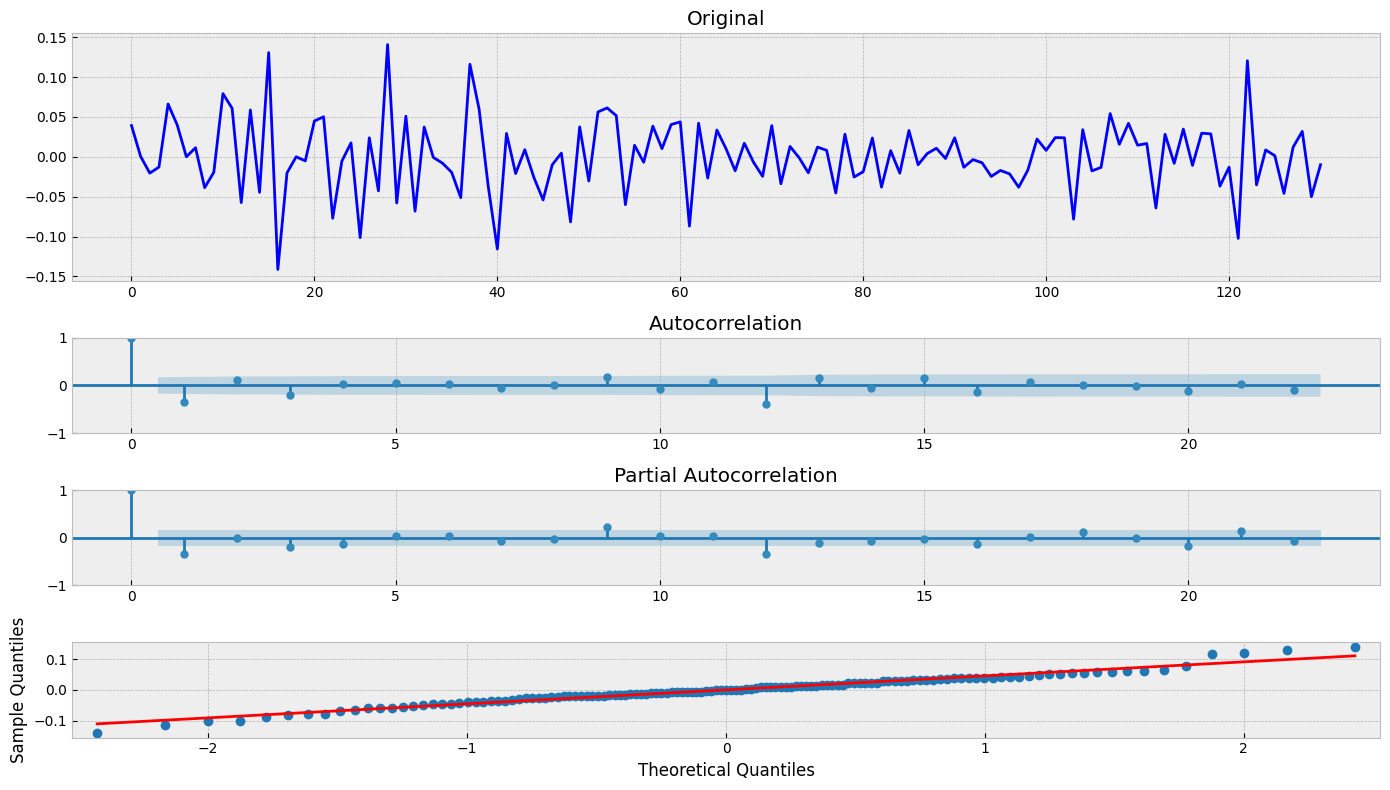

In [ ]:
# Считываем данные из CSV
series = pd.read_csv("international-airline-passengers.csv")['Count']

# Применяем преобразование Бокса-Кокса к временным рядам
series = boxcox(series, 0)

# Вычисляем сезонные различия
seasonal_diff = series[12:] - series[:-12]

# Вычисляем первый порядок разности
first_diff = seasonal_diff[1:] - seasonal_diff[:-1]

# Визуализация
tsplot(first_diff)

Вывод: временной ряд стационарен.

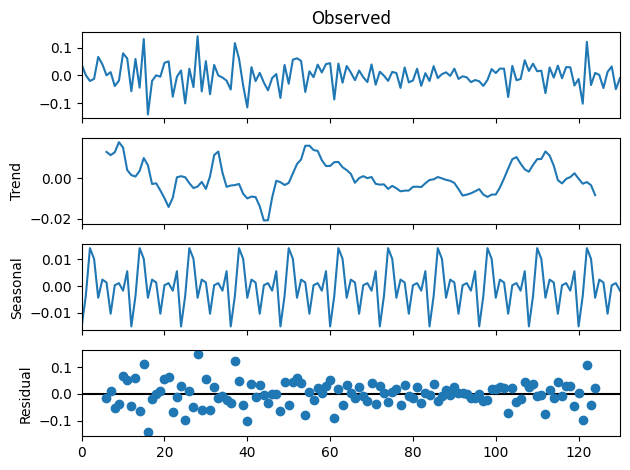

In [ ]:
# Декомпозиция временного ряда first_diff
decomposition = seasonal_decompose(first_diff, model='additive', period=12)

# Визуализация
fig = decomposition.plot()
plt.show()

Наблюдаем сезонность в стационарном ряде first_diff.

На основе результатов теста Дики-Фуллера мы можем сделать вывод, что ваш временной ряд стационарен, поскольку p-value значительно ниже 0.05 и тестовая статистика ниже критических значений при всех уровнях значимости (1%, 5%, 10%).

# Разбиение данных

Размер обучающей выборки: 104
Размер тестовой выборки: 27


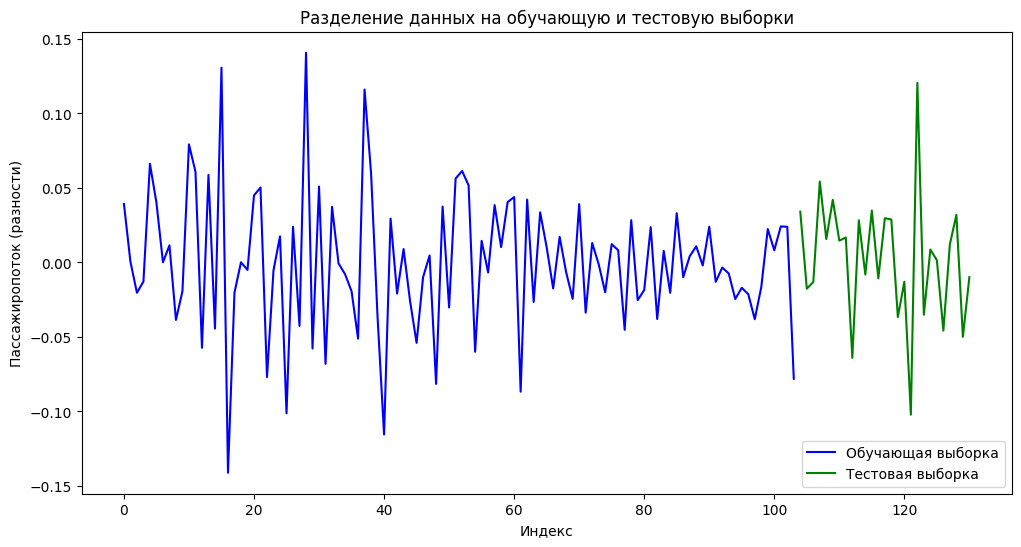

In [ ]:
# Общее количество наблюдений
n = len(first_diff)

# Определяем размер обучающей выборки (например, 80% от общего числа наблюдений)
train_size = int(n * 0.8)

# Разделяем данные на обучающую и тестовую выборки
train, test = first_diff[:train_size], first_diff[train_size:]

# Преобразуем массивы back в pandas Series
train_series = pd.Series(train)
test_series = pd.Series(test)

# Выводим размеры обучающей и тестовой выборок
print(f"Размер обучающей выборки: {len(train_series)}")
print(f"Размер тестовой выборки: {len(test_series)}")

# Для наглядности можно построить график
plt.figure(figsize=(12, 6))
plt.plot(train_series.index, train_series, label='Обучающая выборка', color='blue')
plt.plot(test_series.index + train_size, test_series, label='Тестовая выборка', color='green') # Изменяем индекс тестовой выборки
plt.title('Разделение данных на обучающую и тестовую выборки')
plt.xlabel('Индекс')
plt.ylabel('Пассажиропоток (разности)')
plt.legend()
plt.show()

# Перейдем к построению модели ARIMA

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
# Обучите модель ARIMA(1, 1, 1)
model = ARIMA(train_series, order=(1, 1, 1))
model_fit = model.fit()

# Вывод информации о модели
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  104
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 172.477
Date:                Tue, 04 Mar 2025   AIC                           -338.954
Time:                        16:54:31   BIC                           -331.050
Sample:                             0   HQIC                          -335.753
                                - 104                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3182      0.073     -4.383      0.000      -0.461      -0.176
ma.L1         -1.0000     51.234     -0.020      0.984    -101.416      99.416
sigma2         0.0020      0.100      0.020      0.9

In [ ]:
# Подберем гиперпараметры для модели
import itertools
from tqdm import tqdm

In [ ]:
def get_best_params(series):
  p = range(0,10)
  d = range(0,10)
  q = range(0,10)
  pdq = list(itertools.product(p, d, q))
  best_pdq = (0,0,0)
  best_aic = np.inf
  for params in tqdm(pdq):
    try:
      model_test = ARIMA(series, order = params)
      result_test = model_test.fit()
      if result_test.aic < best_aic:
        best_pdq = params
        best_aic = result_test.aic
    except:
      pass
  return best_pdq

In [ ]:
best_params = get_best_params(train)

  1%|          | 7/1000 [00:01<05:17,  3.13it/s]/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  1%|          | 8/1000 [00:02<06:53,  2.40it/s]/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  1%|          | 9/1000 [00:03<08:36,  1.92it/s]/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  1%|▏         | 13/1000 [00:07<11:26,  1.44it/s]/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. 

In [ ]:
print(best_params)


(3, 0, 2)


In [ ]:
# Прогнозируем следующие значения на основе обученной модели
forecast = model_fit.forecast(steps=len(test_series))

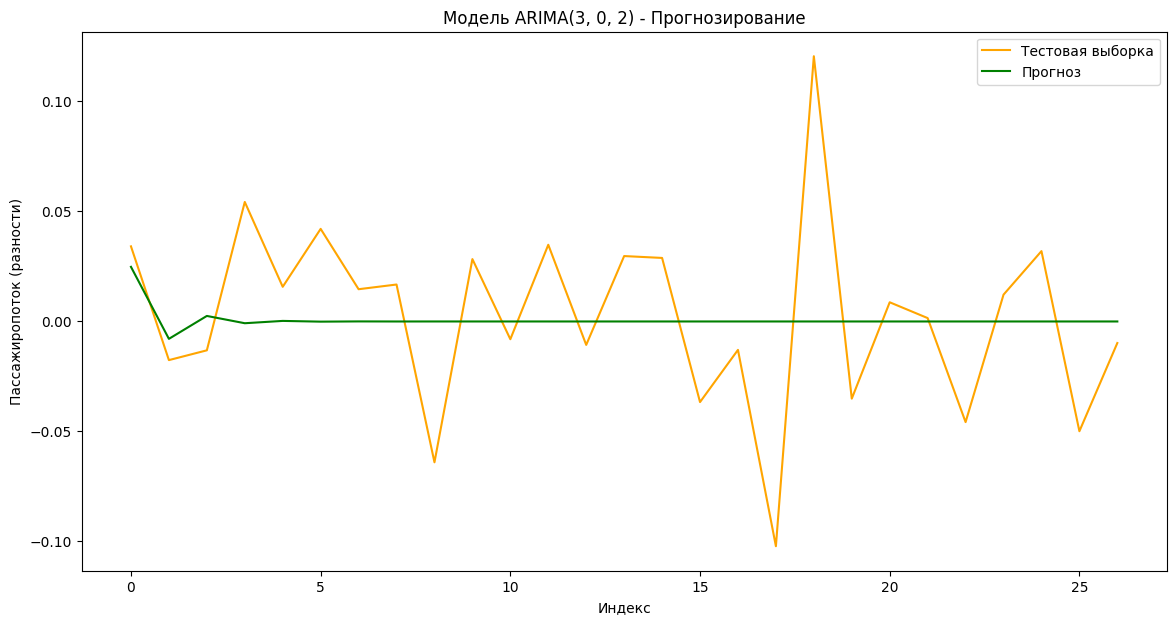

In [ ]:
# Построим график прогноза
plt.figure(figsize=(14, 7))
plt.plot(test_series.index, test_series, label='Тестовая выборка', color='orange')
plt.plot(test_series.index, forecast, label='Прогноз', color='green')
plt.title('Модель ARIMA(3, 0, 2) - Прогноз')
plt.xlabel('Индекс')
plt.ylabel('Пассажиропоток (разности)')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score

# Рассчет RMSE
rmse = sqrt(mean_squared_error(test_series, forecast))
print(f'RMSE: {rmse:.2f}')

# Рассчет R-squared
r_squared = 1 - (mean_squared_error(test_series, forecast) / np.var(test_series))
print(f'R-squared: {r_squared:.2f}')

RMSE: 0.04
R-squared: 0.02


## Вывод по результатам ARIMA



Низкие значения R-squared свидетельствуют о том, что модель ARIMA объясняет всего около 2% вариации в данных. Это может указывать на недостаточность модели.

# Используем модель Random Forest

In [ ]:
from sklearn.linear_model import LinearRegression

# Подготовка данных для линейной регрессии
def create_lags(data, lag_count):
    """Создает лаги для временного ряда."""
    # Преобразуем в DataFrame
    df = pd.DataFrame(data)

    # Создание лагов
    for lag in range(1, lag_count + 1):
        df[f'lag_{lag}'] = df[0].shift(lag)

    # Удаляем строки с NaN
    return df.dropna()

# Создание лагов
lags_count = 12  # количество лагов
lagged_data = create_lags(first_diff, lags_count)


# Разделение данных на признаки и целевую переменную
X = lagged_data.drop(columns=[0])  # Признаки (лаговые значения)
y = lagged_data[0]  # Целевая переменная

# Проверим, как это работает
print(X.head())
print("-----------------------")
print(y.head())

       lag_1     lag_2     lag_3     lag_4     lag_5     lag_6     lag_7  \
12  0.060844  0.079150 -0.019418 -0.038715  0.011354  0.000000  0.039915   
13 -0.057448  0.060844  0.079150 -0.019418 -0.038715  0.011354  0.000000   
14  0.058670 -0.057448  0.060844  0.079150 -0.019418 -0.038715  0.011354   
15 -0.044548  0.058670 -0.057448  0.060844  0.079150 -0.019418 -0.038715   
16  0.130705 -0.044548  0.058670 -0.057448  0.060844  0.079150 -0.019418   

       lag_8     lag_9    lag_10    lag_11    lag_12  
12  0.066148 -0.012939 -0.020496  0.000361  0.039164  
13  0.039915  0.066148 -0.012939 -0.020496  0.000361  
14  0.000000  0.039915  0.066148 -0.012939 -0.020496  
15  0.011354  0.000000  0.039915  0.066148 -0.012939  
16 -0.038715  0.011354  0.000000  0.039915  0.066148  
-----------------------
12   -0.057448
13    0.058670
14   -0.044548
15    0.130705
16   -0.141343
Name: 0, dtype: float64


In [ ]:
# Разделение данных на обучающую и тестовую выборки
train_size = int(len(X) * 0.8)  # 80% для обучения
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

RMSE (LinearRegression): 0.04
R-squared (LinearRegression): 0.36


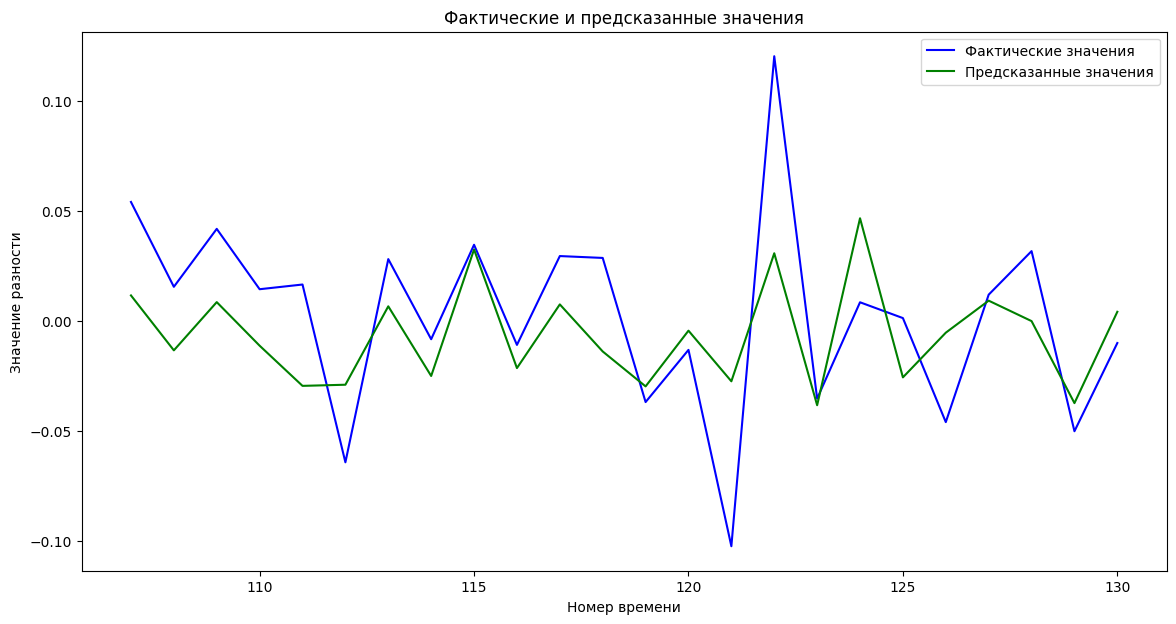

In [ ]:
# Обучаем модель
model = LinearRegression()
model.fit(X_train, y_train)

# Предсказание на тестовых данных
y_pred = model.predict(X_test)

# Оценка модели
from sklearn.metrics import mean_squared_error

# Оценим RMSE
rf_rmse = sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE (LinearRegression): {rf_rmse:.2f}')

# Вычисляем R-squared
r_squared = r2_score(y_test, y_pred)
print(f'R-squared (LinearRegression): {r_squared:.2f}')

# Визуализация
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(y_test.index, y_test, label='Фактические значения', color='blue')
plt.plot(y_test.index, y_pred, label='Предсказанные значения', color='green')
plt.title('Фактические и предсказанные значения')
plt.xlabel('Номер времени')
plt.ylabel('Значение разности')
plt.legend()
plt.show()

# Вывод по результатам LinearRegression

Данная модель показала большую точность по сравнению с ARIMA.

# Прогнозирование временного ряда с использованием Random Forest

RMSE (Random Forest): 0.04
R-squared (Random Forest): 0.10


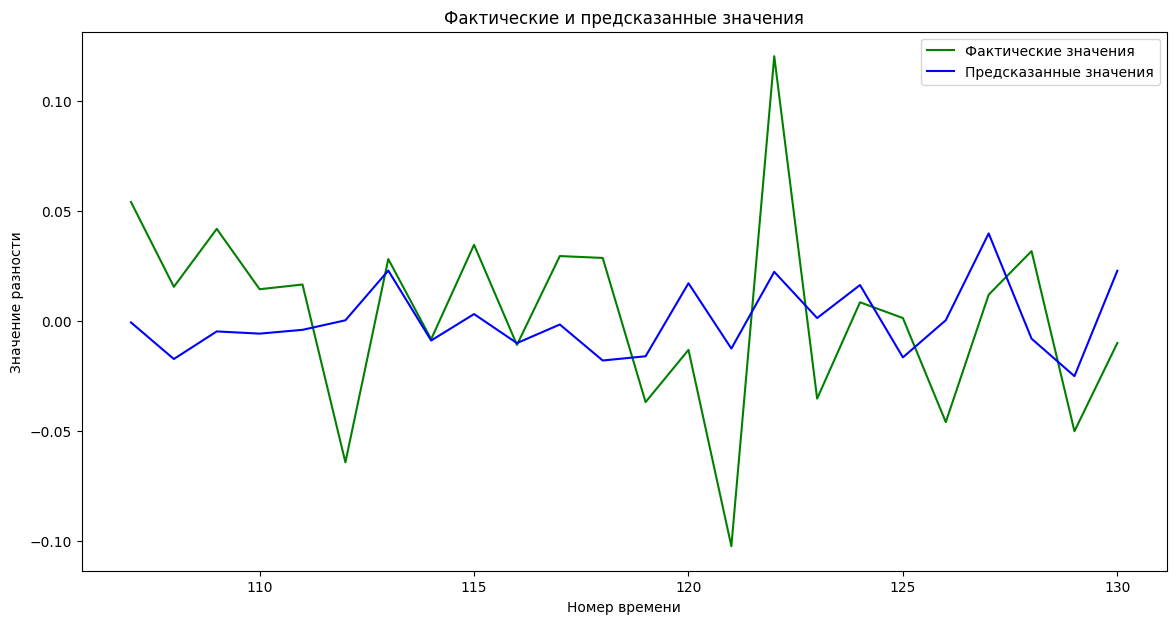

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Обучаем модель Random Forest
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)

# Делаем прогноз
rf_forecast = rf_model.predict(X_test)

# Оценим RMSE
rf_rmse = sqrt(mean_squared_error(y_test, rf_forecast))
print(f'RMSE (Random Forest): {rf_rmse:.2f}')

# Вычисляем R-squared
r_squared = r2_score(y_test, rf_forecast)
print(f'R-squared (Random Forest): {r_squared:.2f}')

# Визуализация
plt.figure(figsize=(14, 7))
plt.plot(y_test.index, y_test, label='Фактические значения', color='green')
plt.plot(y_test.index, rf_forecast, label='Предсказанные значения', color='blue')
plt.title('Фактические и предсказанные значения')
plt.xlabel('Номер времени')
plt.ylabel('Значение разности')
plt.legend()
plt.show()

# Вывод по результатам

RMSE для Random Forest также составил 0.04, также, как и у линейной регрессии. но R-squared = 0.10, что менее эффективно, чем в случае линейной регрессии. Это может означать, что Random Forest не смог улавливать ограничения данных так, как ожидалось, возможно, из-за перерасхода или недостатка решающих деревьев.

Таким образом, самые точные данные были получены при импользовании модели Linear Regression.